<a href="https://colab.research.google.com/github/paigeaera5/Sentiment_Analysis/blob/main/model_development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

**Install Missing Libraries**

In [2]:
%pip install emoji --upgrade
%pip install -q kaggle

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement ntlk (from versions: none)
ERROR: No matching distribution found for ntlk


**Import Necessary Libraries**

In [9]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import string
import codecs
import emoji
import os
import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

from imblearn.over_sampling import SMOTE

import os
from importlib.resources import files

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paige\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Load Data**

In [14]:
dataset_name = 'kazanova/sentiment140'
zip_name = dataset_name.split('/')[-1] + '.zip'

!kaggle datasets download -d {dataset_name}

with ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(os.path.join('.', 'Data'))

os.remove(zip_name)

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


# **Data Cleansing**

## *Read CSV file with specified column names*

In [17]:
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']
df = pd.read_csv("Data/training.1600000.processed.noemoticon.csv",
                 names = col_names,
                 encoding = "ISO-8859-1")
df

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


## *Keep only target and text*

In [18]:
df.drop("id", axis = 1, inplace = True)
df.drop("date", axis = 1, inplace = True)
df.drop("flag", axis = 1, inplace = True)
df.drop("user", axis = 1, inplace = True)

df.shape

(1600000, 2)

## *Check for missing values*

In [19]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [20]:
# Number of texts for each target (0=negative, 2=neutral, 4=positive)
target_group = df.groupby('target')
target_group.count()

,text
target,
0,800000
4,800000


Database has no neutral data although the description stated it did. So we will treat this dataset as only identifying text as positive or negative sentiments.

## *Update target values*

*   0 = negative
*   1 = positive



In [21]:
df.replace({'target':{4:1}}, inplace = True)

## *Check target distribution*

<Axes: ylabel='text'>

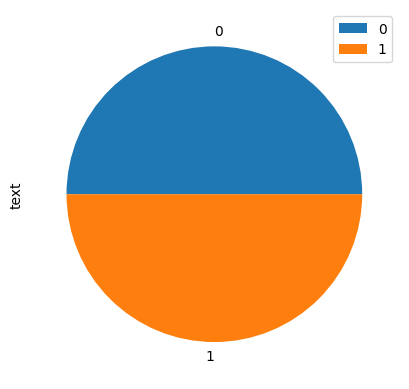

In [22]:
target_group = df.groupby('target')
target_group.count().plot(kind='pie', y='text')

# **Preprocessing**

## *Remove URLs and HTMLs*

In [24]:
def remove_urls(text):
    return re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(<.*?>))', '', text,
                  flags=re.MULTILINE)

df['text'] = df['text'].apply(remove_urls)
df.head()

,target,text
0,0,"@switchfoot - Awww, that's a bummer. You sho..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## *Remove mentions and hashtags*

In [25]:
def remove_mentions(text):
    return re.sub(r'\@\w+|\#','', text)

df['text'] = df['text'].apply(remove_mentions)
df.head()

,target,text
0,0,"- Awww, that's a bummer. You shoulda got Da..."
1,0,is upset that he can't update his Facebook by ...
2,0,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am..."


## *Remove special characters and whitespace*

In [26]:
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return clean_text.strip()

df['text'] = df['text'].apply(remove_special_characters)
df.head()

,target,text
0,0,Awww thats a bummer You shoulda got David Car...
1,0,is upset that he cant update his Facebook by t...
2,0,I dived many times for the ball Managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i her...


## *Convert to lowercase*

In [27]:
df['text']=df['text'].str.lower()
df.head()

,target,text
0,0,awww thats a bummer you shoulda got david car...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i her...


## *Remove punctuations*

In [28]:
punctuations = string.punctuation
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuations))

df['text'] = df['text'].apply(remove_punctuation)
df.head()

,target,text
0,0,awww thats a bummer you shoulda got david car...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i her...


## *Remove stopwords from text*

In [30]:
stopwords_list = set(stopwords.words('english'))

In [31]:
# Function to remove stop words
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords_list])

df['text'] = df['text'].apply(remove_stopwords)
df.head()

,target,text
0,0,awww thats bummer shoulda got david carr third...
1,0,upset cant update facebook texting might cry r...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving im mad cant see


## *Handle emojis*

In [32]:
def remove_emojis(text):
    return emoji.demojize(text)

df['text'] = df['text'].apply(remove_emojis)

df.head()

,target,text
0,0,awww thats bummer shoulda got david carr third...
1,0,upset cant update facebook texting might cry r...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving im mad cant see


## *Save cleaned data*

In [33]:
# Save cleaned data
df.to_csv("Data/cleaned-data.csv", index=False)

# **Word Cloud Generation**

In [34]:
# Function to generate word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords_list,
                      min_font_size=10)

## *Positive sentiment*

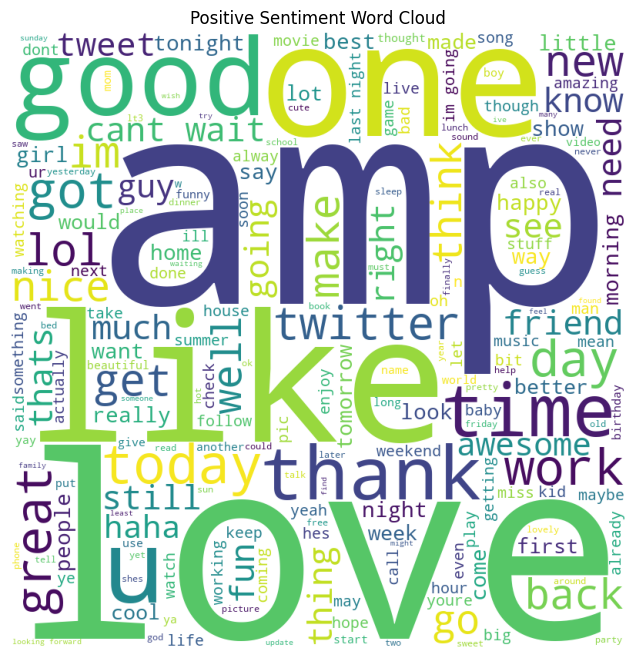

In [35]:
positives = df[df['target'] == 1]
positive_cloud = wordcloud.generate(''.join(positives['text']))

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(positive_cloud)
plt.axis("off")
plt.title('Positive Sentiment Word Cloud')
plt.show()

## *Negative sentiment*

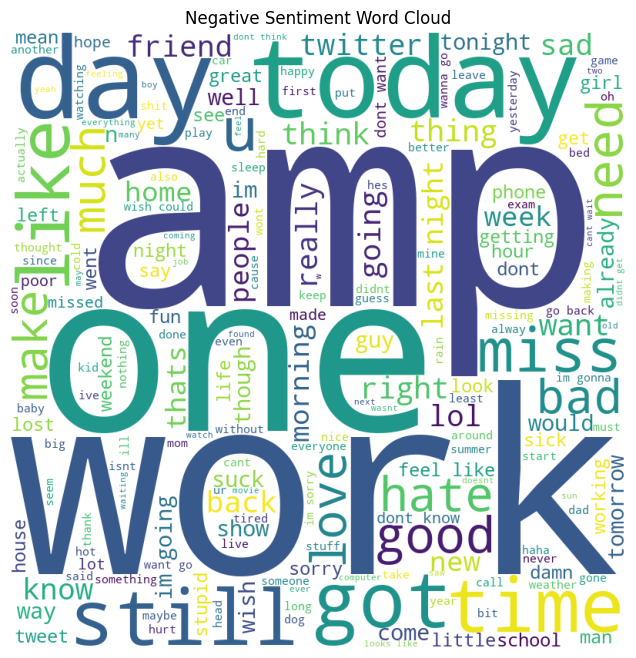

In [36]:
negatives = df[df['target'] == 0]
negative_cloud = wordcloud.generate(''.join(negatives['text']))

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(negative_cloud)
plt.axis("off")
plt.title('Negative Sentiment Word Cloud')
plt.show()

# **Tokenize and Split Data**

In [39]:
tokenizer = TweetTokenizer()
vectorizer = TfidfVectorizer(encoding="utf-8",
                             lowercase=True,
                             tokenizer=tokenizer.tokenize)
x = vectorizer.fit_transform(df['text'])
y = df['target']

In [48]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

In [41]:
y_train.value_counts()

target
0    640506
1    639494
Name: count, dtype: int64

In [42]:
x

<1600000x436238 sparse matrix of type '<class 'numpy.float64'>'
	with 11389735 stored elements in Compressed Sparse Row format>

# **Model Training and Testing**

In [46]:
# Train a Logistic Regression model
clf = LogisticRegression(
    fit_intercept=True, solver='liblinear'
)
clf.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(x_test)

# Evaluate the model
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.76      0.78    159494
           1       0.77      0.81      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.78      0.78    320000
weighted avg       0.79      0.79      0.78    320000



In [66]:
# Train a Logistic Regression model
clf = LogisticRegression(
    fit_intercept=True, solver='liblinear'
)
clf.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(x_test)

# Evaluate the model
report = classification_report(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.76      0.78    159494
           1       0.78      0.81      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



# **Save Model and Results**

In [51]:
# Save classification report
with codecs.open("model_report.txt", "w", encoding = "utf-8") as f:
    f.write(report)

# Save model
with open("sentiment_model.pkl", "wb") as handle:
    pickle.dump(clf, handle)